### Exploring overfitting in NLP
One of the major reasons for the overfitting is, the training dataset is quite small, and with a small number of words. 
Embeddings derived from this may be over generalized also. So in this notebook we’re going to train on a large dataset, as well as using transfer learning of an existing set of embeddings.
The dataset is from:  https://www.kaggle.com/kazanova/sentiment140. The embeddings that we will transfer learn from are called the GloVe, also known as Global Vectors for Word Representation, available at: https://nlp.stanford.edu/projects/glove/

In [13]:
# import required libraries
import tensorflow as tf
import csv
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
# Dimension of the dense embedding. Each word will be represented as a 100-dimensional vector.
embedding_dim = 100 
# Maximum length of all sequences. Sequences longer than this will be truncated, and shorter ones will be padded.
max_length = 16      
# Truncate sequences from the end (post) if they exceed the maximum length.
trunc_type = 'post'    
# Pad sequences at the end (post) to ensure all sequences are of the same length.
padding_type = 'post'  
# Token used to represent words that are out-of-vocabulary (i.e., not present in the training set).
oov_tok = "<OOV>"    
# Number of samples to be used for training.
training_size = 160000 
# Proportion of the data to be used for testing.
test_portion = 0.1

In [7]:
# import dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O D:/Tanuj/Projects/Deep_Learning_TensorFlow/Natural-Language-Processing-in-TensorFlow/training_cleaned.csv

--2024-06-14 17:56:38--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:811::201b, 2a00:1450:4001:812::201b, 2a00:1450:4001:813::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:811::201b|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-06-14 17:56:39 ERROR 404: Not Found.



In [ ]:
corpus = []               # Initialize an empty list to store the sentences and their corresponding labels.
num_sentences = 0         # Counter to keep track of the number of sentences processed.

# Open the CSV file containing the dataset.
with open("Sentiment140_dataset/training_cleaned.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')  # Create a CSV reader to parse the file.
    
    # Iterate over each row in the CSV file.
    for row in reader:
        list_item = []                 # Initialize an empty list to store the current sentence and its label.
        list_item.append(row[5])       # Append the sentence (found in the 6th column) to the list.
        
        this_label = row[0]            # Extract the label (found in the 1st column).
        if this_label == '0':          # Check if the label is '0' (indicating negative sentiment).
            list_item.append(0)        # Append 0 to the list for negative sentiment.
        else:                          # Otherwise, it is a positive sentiment.
            list_item.append(1)        # Append 1 to the list for positive sentiment.
        
        num_sentences += 1             # Increment the sentence counter.
        corpus.append(list_item)       # Add the current sentence and its label to the corpus.

In [ ]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

In [13]:
sentences = []              # Initialize an empty list to store the sentences.
labels = []                 # Initialize an empty list to store the labels.
random.shuffle(corpus)      # Shuffle the corpus to ensure the data is randomly distributed.

# Loop through the first `training_size` elements of the shuffled corpus.
for x in range(training_size):
    sentences.append(corpus[x][0])  # Append the sentence part of the corpus element to the sentences list.
    labels.append(corpus[x][1])     # Append the label part of the corpus element to the labels list.

tokenizer = Tokenizer()             # Initialize the tokenizer.
tokenizer.fit_on_texts(sentences)   # Fit the tokenizer on the list of sentences.

word_index = tokenizer.word_index   # Get the word index dictionary that maps words to their index.
vocab_size = len(word_index)        # Calculate the vocabulary size.

# Convert the sentences to sequences of integers.
sequences = tokenizer.texts_to_sequences(sentences)
# Pad the sequences to ensure they all have the same length.
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)  # Calculate the number of samples for the test set.

# Split the padded sequences and labels into training and test sets.
test_sequences = padded[0:split]           # Get the test sequences.
training_sequences = padded[split:training_size]  # Get the training sequences.
test_labels = labels[0:split]              # Get the test labels.
training_labels = labels[split:training_size]  # Get the training labels.

In [14]:
print(vocab_size)
print(word_index['i'])

138631
1


In [19]:
# Note this is the 100 dimension version of GloVe from Stanford

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O D:/Tanuj/Projects/Deep_Learning_TensorFlow/Natural-Language-Processing-in-TensorFlow/Glove_dataset/glove.6B.100d.txt

embeddings_index = {}  # Initialize an empty dictionary to store the embeddings for each word.

# Open the GloVe embeddings file.
with open('Glove_dataset/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split()  # Split each line into its components.
        word = values[0]       # The first value is the word.
        coefs = np.asarray(values[1:], dtype='float32')  # The remaining values are the word's embedding coefficients.
        embeddings_index[word] = coefs  # Store the word and its coefficients in the embeddings index.

# Initialize the embeddings matrix with zeros. The matrix has dimensions (vocab_size + 1, embedding_dim).
embeddings_matrix = np.zeros((vocab_size + 1, embedding_dim))

# Loop over the word index dictionary to populate the embeddings matrix.
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)  # Get the embedding vector for the word from the embeddings index.
    if embedding_vector is not None:  # If the embedding vector exists (i.e., the word is in the GloVe embeddings).
        embeddings_matrix[i] = embedding_vector  # Assign the embedding vector to the corresponding index in the matrix.

print(len(embeddings_matrix)) 

--2020-11-24 00:05:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4001:80b::2010, 2a00:1450:4001:81e::2010, 2a00:1450:4001:820::2010, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4001:80b::2010|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: '/Users/tanuj/Natural-Language-Processing-in-TensorFlow/Glove_dataset/glove.6B.100d.txt'

     0K .......... .......... .......... .......... ..........  0%  590K 9m35s
    50K .......... .......... .......... .......... ..........  0% 3.41M 5m36s
   100K .......... .......... .......... .......... ..........  0% 3.38M 4m17s
   150K .......... .......... .......... .......... ..........  0% 3.42M 3m37s
   200K .......... .......... .......... .......... ..........  0% 3.37M 3m13s
   250K .......... .......... .......... .......... .......... 

 10500K .......... .......... .......... .......... ..........  3% 25.2M 57s
 10550K .......... .......... .......... .......... ..........  3% 14.5M 57s
 10600K .......... .......... .......... .......... ..........  3% 24.3M 57s
 10650K .......... .......... .......... .......... ..........  3% 24.1M 57s
 10700K .......... .......... .......... .......... ..........  3% 24.7M 57s
 10750K .......... .......... .......... .......... ..........  3% 20.6M 56s
 10800K .......... .......... .......... .......... ..........  3% 27.9M 56s
 10850K .......... .......... .......... .......... ..........  3% 26.3M 56s
 10900K .......... .......... .......... .......... ..........  3% 27.2M 56s
 10950K .......... .......... .......... .......... ..........  3% 23.3M 56s
 11000K .......... .......... .......... .......... ..........  3% 25.1M 55s
 11050K .......... .......... .......... .......... ..........  3% 27.5M 55s
 11100K .......... .......... .......... .......... ..........  3% 24.1M 55s

 27750K .......... .......... .......... .......... ..........  8% 25.0M 29s
 27800K .......... .......... .......... .......... ..........  8% 23.9M 29s
 27850K .......... .......... .......... .......... ..........  8% 15.0M 29s
 27900K .......... .......... .......... .......... ..........  8% 25.9M 29s
 27950K .......... .......... .......... .......... ..........  8% 27.3M 29s
 28000K .......... .......... .......... .......... ..........  8% 22.3M 29s
 28050K .......... .......... .......... .......... ..........  8% 26.7M 29s
 28100K .......... .......... .......... .......... ..........  8% 26.7M 29s
 28150K .......... .......... .......... .......... ..........  8% 23.1M 28s
 28200K .......... .......... .......... .......... ..........  8% 22.7M 28s
 28250K .......... .......... .......... .......... ..........  8% 27.2M 28s
 28300K .......... .......... .......... .......... ..........  8% 28.2M 28s
 28350K .......... .......... .......... .......... ..........  8% 25.9M 28s

 33850K .......... .......... .......... .......... .......... 10% 25.0M 25s
 33900K .......... .......... .......... .......... .......... 10% 21.0M 25s
 33950K .......... .......... .......... .......... .......... 10% 23.2M 25s
 34000K .......... .......... .......... .......... .......... 10% 20.1M 25s
 34050K .......... .......... .......... .......... .......... 10% 20.0M 25s
 34100K .......... .......... .......... .......... .......... 10% 22.6M 25s
 34150K .......... .......... .......... .......... .......... 10% 24.6M 25s
 34200K .......... .......... .......... .......... .......... 10% 20.5M 25s
 34250K .......... .......... .......... .......... .......... 10% 24.8M 25s
 34300K .......... .......... .......... .......... .......... 10% 26.3M 25s
 34350K .......... .......... .......... .......... .......... 10% 25.2M 25s
 34400K .......... .......... .......... .......... .......... 10% 21.2M 25s
 34450K .......... .......... .......... .......... .......... 10% 25.3M 25s

 48550K .......... .......... .......... .......... .......... 14% 27.3M 20s
 48600K .......... .......... .......... .......... .......... 14% 22.5M 20s
 48650K .......... .......... .......... .......... .......... 14% 27.2M 20s
 48700K .......... .......... .......... .......... .......... 14% 25.5M 20s
 48750K .......... .......... .......... .......... .......... 14% 26.5M 20s
 48800K .......... .......... .......... .......... .......... 14% 22.2M 20s
 48850K .......... .......... .......... .......... .......... 14% 27.1M 20s
 48900K .......... .......... .......... .......... .......... 14% 25.7M 20s
 48950K .......... .......... .......... .......... .......... 14% 27.2M 20s
 49000K .......... .......... .......... .......... .......... 14% 22.9M 20s
 49050K .......... .......... .......... .......... .......... 14% 27.1M 20s
 49100K .......... .......... .......... .......... .......... 14% 26.3M 20s
 49150K .......... .......... .......... .......... .......... 14% 25.8M 20s

 56850K .......... .......... .......... .......... .......... 16% 25.8M 19s
 56900K .......... .......... .......... .......... .......... 16% 22.7M 19s
 56950K .......... .......... .......... .......... .......... 16% 21.7M 19s
 57000K .......... .......... .......... .......... .......... 16% 23.2M 19s
 57050K .......... .......... .......... .......... .......... 16% 25.8M 19s
 57100K .......... .......... .......... .......... .......... 16% 26.0M 19s
 57150K .......... .......... .......... .......... .......... 16% 22.8M 19s
 57200K .......... .......... .......... .......... .......... 16% 21.5M 19s
 57250K .......... .......... .......... .......... .......... 16% 22.6M 19s
 57300K .......... .......... .......... .......... .......... 16% 24.4M 19s
 57350K .......... .......... .......... .......... .......... 16% 23.2M 19s
 57400K .......... .......... .......... .......... .......... 16% 17.2M 19s
 57450K .......... .......... .......... .......... .......... 16% 20.7M 19s

 69700K .......... .......... .......... .......... .......... 20% 27.7M 17s
 69750K .......... .......... .......... .......... .......... 20% 26.5M 17s
 69800K .......... .......... .......... .......... .......... 20% 24.6M 17s
 69850K .......... .......... .......... .......... .......... 20% 25.8M 17s
 69900K .......... .......... .......... .......... .......... 20% 27.6M 17s
 69950K .......... .......... .......... .......... .......... 20% 24.6M 17s
 70000K .......... .......... .......... .......... .......... 20% 17.8M 17s
 70050K .......... .......... .......... .......... .......... 20% 22.5M 17s
 70100K .......... .......... .......... .......... .......... 20% 24.1M 17s
 70150K .......... .......... .......... .......... .......... 20% 26.1M 17s
 70200K .......... .......... .......... .......... .......... 20% 23.3M 17s
 70250K .......... .......... .......... .......... .......... 20% 26.0M 17s
 70300K .......... .......... .......... .......... .......... 20% 21.8M 17s

 79800K .......... .......... .......... .......... .......... 23% 23.7M 15s
 79850K .......... .......... .......... .......... .......... 23% 26.7M 15s
 79900K .......... .......... .......... .......... .......... 23% 28.3M 15s
 79950K .......... .......... .......... .......... .......... 23% 28.1M 15s
 80000K .......... .......... .......... .......... .......... 23% 23.1M 15s
 80050K .......... .......... .......... .......... .......... 23% 28.2M 15s
 80100K .......... .......... .......... .......... .......... 23% 26.5M 15s
 80150K .......... .......... .......... .......... .......... 23% 28.1M 15s
 80200K .......... .......... .......... .......... .......... 23% 18.6M 15s
 80250K .......... .......... .......... .......... .......... 23% 28.5M 15s
 80300K .......... .......... .......... .......... .......... 23% 28.4M 15s
 80350K .......... .......... .......... .......... .......... 23% 27.1M 15s
 80400K .......... .......... .......... .......... .......... 23% 23.4M 15s

 93950K .......... .......... .......... .......... .......... 27% 20.2M 14s
 94000K .......... .......... .......... .......... .......... 27% 19.5M 14s
 94050K .......... .......... .......... .......... .......... 27% 22.1M 14s
 94100K .......... .......... .......... .......... .......... 27% 22.4M 14s
 94150K .......... .......... .......... .......... .......... 27% 23.9M 14s
 94200K .......... .......... .......... .......... .......... 27% 20.0M 14s
 94250K .......... .......... .......... .......... .......... 27% 22.9M 14s
 94300K .......... .......... .......... .......... .......... 27% 22.0M 14s
 94350K .......... .......... .......... .......... .......... 27% 22.2M 14s
 94400K .......... .......... .......... .......... .......... 27% 19.7M 14s
 94450K .......... .......... .......... .......... .......... 27% 21.0M 14s
 94500K .......... .......... .......... .......... .......... 27% 23.9M 14s
 94550K .......... .......... .......... .......... .......... 27% 24.9M 14s

109700K .......... .......... .......... .......... .......... 32% 21.7M 13s
109750K .......... .......... .......... .......... .......... 32% 22.3M 13s
109800K .......... .......... .......... .......... .......... 32% 21.0M 13s
109850K .......... .......... .......... .......... .......... 32% 24.9M 13s
109900K .......... .......... .......... .......... .......... 32% 24.0M 13s
109950K .......... .......... .......... .......... .......... 32% 20.3M 13s
110000K .......... .......... .......... .......... .......... 32% 19.8M 13s
110050K .......... .......... .......... .......... .......... 32% 22.3M 13s
110100K .......... .......... .......... .......... .......... 32% 22.8M 13s
110150K .......... .......... .......... .......... .......... 32% 22.0M 13s
110200K .......... .......... .......... .......... .......... 32% 19.3M 13s
110250K .......... .......... .......... .......... .......... 32% 22.8M 13s
110300K .......... .......... .......... .......... .......... 32% 23.7M 13s

120500K .......... .......... .......... .......... .......... 35% 24.4M 12s
120550K .......... .......... .......... .......... .......... 35% 23.8M 12s
120600K .......... .......... .......... .......... .......... 35% 20.4M 12s
120650K .......... .......... .......... .......... .......... 35% 9.92M 12s
120700K .......... .......... .......... .......... .......... 35% 14.5M 12s
120750K .......... .......... .......... .......... .......... 35% 19.5M 12s
120800K .......... .......... .......... .......... .......... 35% 16.2M 12s
120850K .......... .......... .......... .......... .......... 35% 20.5M 12s
120900K .......... .......... .......... .......... .......... 35% 21.4M 12s
120950K .......... .......... .......... .......... .......... 35% 17.8M 12s
121000K .......... .......... .......... .......... .......... 35% 16.4M 12s
121050K .......... .......... .......... .......... .......... 35% 21.1M 12s
121100K .......... .......... .......... .......... .......... 35% 21.1M 12s

128550K .......... .......... .......... .......... .......... 37% 22.5M 11s
128600K .......... .......... .......... .......... .......... 37% 19.3M 11s
128650K .......... .......... .......... .......... .......... 37% 22.8M 11s
128700K .......... .......... .......... .......... .......... 37% 23.1M 11s
128750K .......... .......... .......... .......... .......... 37% 21.3M 11s
128800K .......... .......... .......... .......... .......... 38% 16.6M 11s
128850K .......... .......... .......... .......... .......... 38% 19.0M 11s
128900K .......... .......... .......... .......... .......... 38% 20.9M 11s
128950K .......... .......... .......... .......... .......... 38% 22.5M 11s
129000K .......... .......... .......... .......... .......... 38% 19.5M 11s
129050K .......... .......... .......... .......... .......... 38% 22.3M 11s
129100K .......... .......... .......... .......... .......... 38% 22.4M 11s
129150K .......... .......... .......... .......... .......... 38% 21.7M 11s

134900K .......... .......... .......... .......... .......... 39% 20.5M 11s
134950K .......... .......... .......... .......... .......... 39% 22.2M 11s
135000K .......... .......... .......... .......... .......... 39% 19.4M 11s
135050K .......... .......... .......... .......... .......... 39% 22.8M 11s
135100K .......... .......... .......... .......... .......... 39% 21.5M 11s
135150K .......... .......... .......... .......... .......... 39% 18.6M 11s
135200K .......... .......... .......... .......... .......... 39% 15.8M 11s
135250K .......... .......... .......... .......... .......... 39% 18.1M 11s
135300K .......... .......... .......... .......... .......... 39% 19.5M 11s
135350K .......... .......... .......... .......... .......... 39% 21.1M 11s
135400K .......... .......... .......... .......... .......... 39% 19.4M 11s
135450K .......... .......... .......... .......... .......... 39% 21.2M 11s
135500K .......... .......... .......... .......... .......... 39% 22.1M 11s

148600K .......... .......... .......... .......... .......... 43% 20.1M 10s
148650K .......... .......... .......... .......... .......... 43% 22.4M 10s
148700K .......... .......... .......... .......... .......... 43% 23.6M 10s
148750K .......... .......... .......... .......... .......... 43% 24.1M 10s
148800K .......... .......... .......... .......... .......... 43% 20.2M 10s
148850K .......... .......... .......... .......... .......... 43% 24.5M 10s
148900K .......... .......... .......... .......... .......... 43% 23.4M 10s
148950K .......... .......... .......... .......... .......... 43% 22.6M 10s
149000K .......... .......... .......... .......... .......... 43% 21.3M 10s
149050K .......... .......... .......... .......... .......... 43% 24.0M 10s
149100K .......... .......... .......... .......... .......... 43% 24.3M 10s
149150K .......... .......... .......... .......... .......... 44% 21.6M 10s
149200K .......... .......... .......... .......... .......... 44% 19.2M 10s

157350K .......... .......... .......... .......... .......... 46% 23.4M 10s
157400K .......... .......... .......... .......... .......... 46% 20.5M 10s
157450K .......... .......... .......... .......... .......... 46% 21.0M 10s
157500K .......... .......... .......... .......... .......... 46% 23.6M 10s
157550K .......... .......... .......... .......... .......... 46% 23.8M 10s
157600K .......... .......... .......... .......... .......... 46% 18.9M 10s
157650K .......... .......... .......... .......... .......... 46% 22.4M 10s
157700K .......... .......... .......... .......... .......... 46% 23.8M 10s
157750K .......... .......... .......... .......... .......... 46% 22.0M 10s
157800K .......... .......... .......... .......... .......... 46% 22.0M 10s
157850K .......... .......... .......... .......... .......... 46% 23.1M 10s
157900K .......... .......... .......... .......... .......... 46% 24.0M 10s
157950K .......... .......... .......... .......... .......... 46% 24.6M 10s

173900K .......... .......... .......... .......... .......... 51% 27.2M 9s
173950K .......... .......... .......... .......... .......... 51% 27.2M 9s
174000K .......... .......... .......... .......... .......... 51% 22.1M 9s
174050K .......... .......... .......... .......... .......... 51% 26.7M 9s
174100K .......... .......... .......... .......... .......... 51% 25.7M 9s
174150K .......... .......... .......... .......... .......... 51% 25.5M 9s
174200K .......... .......... .......... .......... .......... 51% 8.27M 9s
174250K .......... .......... .......... .......... .......... 51% 21.3M 9s
174300K .......... .......... .......... .......... .......... 51% 22.4M 9s
174350K .......... .......... .......... .......... .......... 51% 23.6M 9s
174400K .......... .......... .......... .......... .......... 51% 19.5M 9s
174450K .......... .......... .......... .......... .......... 51% 23.5M 9s
174500K .......... .......... .......... .......... .......... 51% 23.6M 9s
174550K ....

186800K .......... .......... .......... .......... .......... 55% 15.7M 8s
186850K .......... .......... .......... .......... .......... 55% 19.6M 8s
186900K .......... .......... .......... .......... .......... 55% 20.6M 8s
186950K .......... .......... .......... .......... .......... 55% 15.5M 8s
187000K .......... .......... .......... .......... .......... 55% 20.8M 8s
187050K .......... .......... .......... .......... .......... 55% 25.1M 8s
187100K .......... .......... .......... .......... .......... 55% 24.0M 8s
187150K .......... .......... .......... .......... .......... 55% 22.4M 8s
187200K .......... .......... .......... .......... .......... 55% 21.5M 8s
187250K .......... .......... .......... .......... .......... 55% 24.0M 8s
187300K .......... .......... .......... .......... .......... 55% 24.7M 8s
187350K .......... .......... .......... .......... .......... 55% 24.0M 8s
187400K .......... .......... .......... .......... .......... 55% 20.7M 8s
187450K ....

201500K .......... .......... .......... .......... .......... 59% 26.1M 7s
201550K .......... .......... .......... .......... .......... 59% 27.8M 7s
201600K .......... .......... .......... .......... .......... 59% 23.7M 7s
201650K .......... .......... .......... .......... .......... 59% 27.7M 7s
201700K .......... .......... .......... .......... .......... 59% 27.1M 7s
201750K .......... .......... .......... .......... .......... 59% 28.5M 7s
201800K .......... .......... .......... .......... .......... 59% 24.2M 7s
201850K .......... .......... .......... .......... .......... 59% 28.0M 7s
201900K .......... .......... .......... .......... .......... 59% 27.7M 7s
201950K .......... .......... .......... .......... .......... 59% 28.5M 7s
202000K .......... .......... .......... .......... .......... 59% 24.4M 7s
202050K .......... .......... .......... .......... .......... 59% 27.4M 7s
202100K .......... .......... .......... .......... .......... 59% 26.9M 7s
202150K ....

214550K .......... .......... .......... .......... .......... 63% 22.0M 6s
214600K .......... .......... .......... .......... .......... 63% 21.4M 6s
214650K .......... .......... .......... .......... .......... 63% 17.4M 6s
214700K .......... .......... .......... .......... .......... 63% 23.2M 6s
214750K .......... .......... .......... .......... .......... 63% 23.4M 6s
214800K .......... .......... .......... .......... .......... 63% 21.2M 6s
214850K .......... .......... .......... .......... .......... 63% 24.8M 6s
214900K .......... .......... .......... .......... .......... 63% 24.2M 6s
214950K .......... .......... .......... .......... .......... 63% 25.6M 6s
215000K .......... .......... .......... .......... .......... 63% 21.4M 6s
215050K .......... .......... .......... .......... .......... 63% 25.6M 6s
215100K .......... .......... .......... .......... .......... 63% 24.6M 6s
215150K .......... .......... .......... .......... .......... 63% 25.8M 6s
215200K ....

226950K .......... .......... .......... .......... .......... 66% 24.5M 6s
227000K .......... .......... .......... .......... .......... 66% 21.9M 6s
227050K .......... .......... .......... .......... .......... 66% 26.4M 6s
227100K .......... .......... .......... .......... .......... 67% 23.5M 6s
227150K .......... .......... .......... .......... .......... 67% 27.2M 6s
227200K .......... .......... .......... .......... .......... 67% 22.3M 6s
227250K .......... .......... .......... .......... .......... 67% 27.4M 6s
227300K .......... .......... .......... .......... .......... 67% 25.6M 6s
227350K .......... .......... .......... .......... .......... 67% 27.0M 6s
227400K .......... .......... .......... .......... .......... 67% 23.4M 6s
227450K .......... .......... .......... .......... .......... 67% 26.3M 6s
227500K .......... .......... .......... .......... .......... 67% 27.3M 6s
227550K .......... .......... .......... .......... .......... 67% 26.1M 6s
227600K ....

235550K .......... .......... .......... .......... .......... 69% 21.7M 5s
235600K .......... .......... .......... .......... .......... 69% 18.5M 5s
235650K .......... .......... .......... .......... .......... 69% 21.9M 5s
235700K .......... .......... .......... .......... .......... 69% 22.1M 5s
235750K .......... .......... .......... .......... .......... 69% 20.4M 5s
235800K .......... .......... .......... .......... .......... 69% 19.2M 5s
235850K .......... .......... .......... .......... .......... 69% 22.3M 5s
235900K .......... .......... .......... .......... .......... 69% 20.9M 5s
235950K .......... .......... .......... .......... .......... 69% 21.6M 5s
236000K .......... .......... .......... .......... .......... 69% 17.5M 5s
236050K .......... .......... .......... .......... .......... 69% 21.4M 5s
236100K .......... .......... .......... .......... .......... 69% 20.5M 5s
236150K .......... .......... .......... .......... .......... 69% 18.7M 5s
236200K ....

243000K .......... .......... .......... .......... .......... 71% 22.5M 5s
243050K .......... .......... .......... .......... .......... 71% 24.1M 5s
243100K .......... .......... .......... .......... .......... 71% 25.4M 5s
243150K .......... .......... .......... .......... .......... 71% 22.9M 5s
243200K .......... .......... .......... .......... .......... 71% 14.2M 5s
243250K .......... .......... .......... .......... .......... 71% 22.8M 5s
243300K .......... .......... .......... .......... .......... 71% 23.5M 5s
243350K .......... .......... .......... .......... .......... 71% 24.3M 5s
243400K .......... .......... .......... .......... .......... 71% 20.5M 5s
243450K .......... .......... .......... .......... .......... 71% 24.9M 5s
243500K .......... .......... .......... .......... .......... 71% 24.1M 5s
243550K .......... .......... .......... .......... .......... 71% 24.4M 5s
243600K .......... .......... .......... .......... .......... 71% 21.6M 5s
243650K ....

256700K .......... .......... .......... .......... .......... 75% 27.0M 4s
256750K .......... .......... .......... .......... .......... 75% 26.8M 4s
256800K .......... .......... .......... .......... .......... 75% 22.4M 4s
256850K .......... .......... .......... .......... .......... 75% 27.4M 4s
256900K .......... .......... .......... .......... .......... 75% 27.8M 4s
256950K .......... .......... .......... .......... .......... 75% 26.8M 4s
257000K .......... .......... .......... .......... .......... 75% 23.2M 4s
257050K .......... .......... .......... .......... .......... 75% 26.0M 4s
257100K .......... .......... .......... .......... .......... 75% 27.0M 4s
257150K .......... .......... .......... .......... .......... 75% 24.0M 4s
257200K .......... .......... .......... .......... .......... 75% 20.2M 4s
257250K .......... .......... .......... .......... .......... 75% 24.5M 4s
257300K .......... .......... .......... .......... .......... 75% 24.3M 4s
257350K ....

264400K .......... .......... .......... .......... .......... 78% 20.7M 4s
264450K .......... .......... .......... .......... .......... 78% 24.0M 4s
264500K .......... .......... .......... .......... .......... 78% 25.5M 4s
264550K .......... .......... .......... .......... .......... 78% 25.7M 4s
264600K .......... .......... .......... .......... .......... 78% 22.8M 4s
264650K .......... .......... .......... .......... .......... 78% 26.3M 4s
264700K .......... .......... .......... .......... .......... 78% 26.2M 4s
264750K .......... .......... .......... .......... .......... 78% 25.5M 4s
264800K .......... .......... .......... .......... .......... 78% 21.1M 4s
264850K .......... .......... .......... .......... .......... 78% 25.5M 4s
264900K .......... .......... .......... .......... .......... 78% 26.6M 4s
264950K .......... .......... .......... .......... .......... 78% 24.5M 4s
265000K .......... .......... .......... .......... .......... 78% 23.3M 4s
265050K ....

276350K .......... .......... .......... .......... .......... 81% 25.2M 3s
276400K .......... .......... .......... .......... .......... 81% 20.6M 3s
276450K .......... .......... .......... .......... .......... 81% 23.0M 3s
276500K .......... .......... .......... .......... .......... 81% 24.3M 3s
276550K .......... .......... .......... .......... .......... 81% 24.6M 3s
276600K .......... .......... .......... .......... .......... 81% 21.7M 3s
276650K .......... .......... .......... .......... .......... 81% 24.3M 3s
276700K .......... .......... .......... .......... .......... 81% 25.2M 3s
276750K .......... .......... .......... .......... .......... 81% 25.3M 3s
276800K .......... .......... .......... .......... .......... 81% 19.5M 3s
276850K .......... .......... .......... .......... .......... 81% 23.1M 3s
276900K .......... .......... .......... .......... .......... 81% 24.1M 3s
276950K .......... .......... .......... .......... .......... 81% 24.7M 3s
277000K ....

285750K .......... .......... .......... .......... .......... 84% 26.7M 3s
285800K .......... .......... .......... .......... .......... 84% 23.9M 3s
285850K .......... .......... .......... .......... .......... 84% 25.5M 3s
285900K .......... .......... .......... .......... .......... 84% 26.8M 3s
285950K .......... .......... .......... .......... .......... 84% 26.9M 3s
286000K .......... .......... .......... .......... .......... 84% 21.8M 3s
286050K .......... .......... .......... .......... .......... 84% 26.1M 3s
286100K .......... .......... .......... .......... .......... 84% 26.3M 3s
286150K .......... .......... .......... .......... .......... 84% 25.5M 3s
286200K .......... .......... .......... .......... .......... 84% 21.5M 3s
286250K .......... .......... .......... .......... .......... 84% 25.6M 3s
286300K .......... .......... .......... .......... .......... 84% 26.3M 3s
286350K .......... .......... .......... .......... .......... 84% 26.1M 3s
286400K ....

292150K .......... .......... .......... .......... .......... 86% 23.1M 2s
292200K .......... .......... .......... .......... .......... 86% 20.1M 2s
292250K .......... .......... .......... .......... .......... 86% 23.2M 2s
292300K .......... .......... .......... .......... .......... 86% 24.5M 2s
292350K .......... .......... .......... .......... .......... 86% 23.6M 2s
292400K .......... .......... .......... .......... .......... 86% 19.9M 2s
292450K .......... .......... .......... .......... .......... 86% 23.2M 2s
292500K .......... .......... .......... .......... .......... 86% 24.1M 2s
292550K .......... .......... .......... .......... .......... 86% 25.0M 2s
292600K .......... .......... .......... .......... .......... 86% 20.5M 2s
292650K .......... .......... .......... .......... .......... 86% 21.5M 2s
292700K .......... .......... .......... .......... .......... 86% 23.7M 2s
292750K .......... .......... .......... .......... .......... 86% 24.0M 2s
292800K ....

307600K .......... .......... .......... .......... .......... 90% 18.2M 2s
307650K .......... .......... .......... .......... .......... 90% 21.5M 1s
307700K .......... .......... .......... .......... .......... 90% 20.5M 1s
307750K .......... .......... .......... .......... .......... 90% 21.9M 1s
307800K .......... .......... .......... .......... .......... 90% 18.5M 1s
307850K .......... .......... .......... .......... .......... 90% 21.8M 1s
307900K .......... .......... .......... .......... .......... 90% 22.5M 1s
307950K .......... .......... .......... .......... .......... 90% 22.4M 1s
308000K .......... .......... .......... .......... .......... 90% 20.8M 1s
308050K .......... .......... .......... .......... .......... 90% 24.5M 1s
308100K .......... .......... .......... .......... .......... 90% 22.6M 1s
308150K .......... .......... .......... .......... .......... 90% 23.7M 1s
308200K .......... .......... .......... .......... .......... 90% 20.3M 1s
308250K ....

320400K .......... .......... .......... .......... .......... 94% 22.1M 1s
320450K .......... .......... .......... .......... .......... 94% 25.2M 1s
320500K .......... .......... .......... .......... .......... 94% 24.2M 1s
320550K .......... .......... .......... .......... .......... 94% 24.5M 1s
320600K .......... .......... .......... .......... .......... 94% 22.0M 1s
320650K .......... .......... .......... .......... .......... 94% 26.6M 1s
320700K .......... .......... .......... .......... .......... 94% 25.3M 1s
320750K .......... .......... .......... .......... .......... 94% 23.8M 1s
320800K .......... .......... .......... .......... .......... 94% 22.1M 1s
320850K .......... .......... .......... .......... .......... 94% 26.4M 1s
320900K .......... .......... .......... .......... .......... 94% 24.8M 1s
320950K .......... .......... .......... .......... .......... 94% 26.3M 1s
321000K .......... .......... .......... .......... .......... 94% 22.4M 1s
321050K ....

327150K .......... .......... .......... .......... .......... 96% 23.2M 1s
327200K .......... .......... .......... .......... .......... 96% 19.0M 1s
327250K .......... .......... .......... .......... .......... 96% 24.4M 1s
327300K .......... .......... .......... .......... .......... 96% 23.7M 1s
327350K .......... .......... .......... .......... .......... 96% 23.5M 1s
327400K .......... .......... .......... .......... .......... 96% 20.1M 1s
327450K .......... .......... .......... .......... .......... 96% 23.9M 1s
327500K .......... .......... .......... .......... .......... 96% 24.4M 1s
327550K .......... .......... .......... .......... .......... 96% 23.7M 1s
327600K .......... .......... .......... .......... .......... 96% 18.9M 1s
327650K .......... .......... .......... .......... .......... 96% 23.6M 1s
327700K .......... .......... .......... .......... .......... 96% 22.6M 1s
327750K .......... .......... .......... .......... .......... 96% 23.0M 1s
327800K ....

334800K .......... .......... .......... .......... .......... 98% 16.5M 0s
334850K .......... .......... .......... .......... .......... 98% 19.1M 0s
334900K .......... .......... .......... .......... .......... 98% 19.8M 0s
334950K .......... .......... .......... .......... .......... 98% 19.2M 0s
335000K .......... .......... .......... .......... .......... 98% 16.8M 0s
335050K .......... .......... .......... .......... .......... 98% 15.0M 0s
335100K .......... .......... .......... .......... .......... 98% 21.0M 0s
335150K .......... .......... .......... .......... .......... 98% 21.9M 0s
335200K .......... .......... .......... .......... .......... 98% 18.6M 0s
335250K .......... .......... .......... .......... .......... 98% 25.2M 0s
335300K .......... .......... .......... .......... .......... 98% 24.8M 0s
335350K .......... .......... .......... .......... .......... 98% 21.0M 0s
335400K .......... .......... .......... .......... .......... 98% 22.2M 0s
335450K ....

138632


In [21]:
# Initialize a Sequential model.
model = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size + 1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
# Compile the model with binary crossentropy loss, the Adam optimizer, and accuracy as a metric.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary() 

num_epochs = 50  

# Convert the training and testing sequences and labels to numpy arrays.
training_padded = np.array(training_sequences)
training_labels = np.array(training_labels)
testing_padded = np.array(test_sequences)
testing_labels = np.array(test_labels)

# Train the model using the training data and validate using the testing data.
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

print("Training Complete")

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 100)           13863200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 13,928,353
Trainable params: 65,153
Non-trainable params: 13,863,200
_____________________________________

<Figure size 432x288 with 0 Axes>

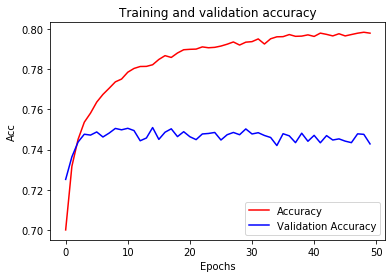

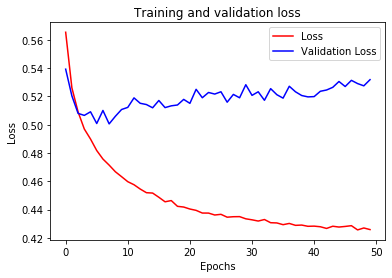

<Figure size 432x288 with 0 Axes>

In [25]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))       # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()
